In [5]:
!python -m pip install git+https://github.com/djcunningham0/multielo.git

  Cloning https://github.com/djcunningham0/multielo.git to /private/var/folders/0s/9k5wnkxx22l_g6lmt5xw673m0000gq/T/pip-req-build-7amrxfdp
  Running command git clone --filter=blob:none --quiet https://github.com/djcunningham0/multielo.git /private/var/folders/0s/9k5wnkxx22l_g6lmt5xw673m0000gq/T/pip-req-build-7amrxfdp
  Resolved https://github.com/djcunningham0/multielo.git to commit 440f7922b90ff87009f8283d6491eb0f704e6624
  Preparing metadata (setup.py) ... done
  DEPRECATION: multielo is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for multielo ... done

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from multielo import MultiElo

In [2]:
elo = MultiElo()

In [3]:
df = pd.read_csv("../data/contest_results.csv", parse_dates=["contest_date"])
df = df[
    [
        "organization",
        "contest_name",
        "contest_date",
        "division",
        "class",
        "competitor_name",
        "placing",
    ]
]
df.loc[df["division"] == "women's wellness", "division"] = "wellness"
df = df.dropna()

In [17]:
df["multielo_rating"] = 1500

In [18]:
df = df.sort_values(
    by=["contest_date", "organization", "contest_name", "division", "class", "placing"],
    ascending=True,
)

In [19]:
df.head()

,organization,contest_name,contest_date,division,class,competitor_name,placing,multielo_rating
17038,ifbb,ifbb flex pro,2012-02-18,fitness,open,adela garcia,1.0,1500
17037,ifbb,ifbb flex pro,2012-02-18,fitness,open,oksana grishina,2.0,1500
17036,ifbb,ifbb flex pro,2012-02-18,fitness,open,myriam capes,3.0,1500
17035,ifbb,ifbb flex pro,2012-02-18,fitness,open,tanji johnson,4.0,1500
17034,ifbb,ifbb flex pro,2012-02-18,fitness,open,bethany wagner,5.0,1500


In [44]:
competitors = {}
starting_elo = {
    "bikini": 1700,
    "figure": 1650,
    "fitness": 1525,
    "men's bodybuilding": 1650,
    "men's classic physique": 1625,
    "men's physique": 1650,
    "wellness": 1575,
    "women's bodybuilding": 1625,
    "women's physique": 1550,
    "212": 1650,
}
df["professional_only"] = (
    df.groupby("competitor_name")["organization"].transform("nunique") == 1
) & (df["organization"] == "ifbb")

for index, row in df.iterrows():
    if row["professional_only"]:
        competitors[row["competitor_name"]] = starting_elo[row["division"]]
    else:
        competitors[row["competitor_name"]] = 1500

In [45]:
df["placing"] = df["placing"].astype(int)

In [46]:
df_groupby = df.groupby(by=["contest_date", "organization", "division", "class"])

In [47]:
for name, df_temp in df_groupby:
    if len(df_temp) < 2:
        continue
    for index, row in df_temp.iterrows():
        name = row["competitor_name"]
        df_temp.loc[index, "multielo_rating"] = competitors[name]
    df_temp["multielo_rating"] = elo.get_new_ratings(
        df_temp["multielo_rating"].values,
        result_order=list(df_temp["placing"].values),
    )
    for index, row in df_temp.iterrows():
        name = row["competitor_name"]
        competitors[name] = row["multielo_rating"]
        df.loc[index, "multielo_rating"] = df_temp.loc[
            index, "multielo_rating"
        ]

In [48]:
df["multielo_rank"] = df.groupby(
    ["organization", "contest_date", "contest_name", "division", "class"]
)["multielo_rating"].rank(ascending=False, method="first")

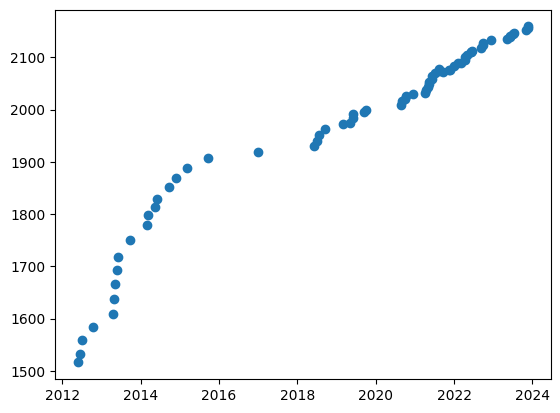

In [49]:
plt.scatter(
    df[df["competitor_name"] == "ashley kaltwasser"]["contest_date"],
    df[df["competitor_name"] == "ashley kaltwasser"]["multielo_rating"],
)

In [50]:
df.head()

,organization,contest_name,contest_date,division,class,competitor_name,placing,multielo_rating,professional_only,multielo_rank
17038,ifbb,ifbb flex pro,2012-02-18,fitness,open,adela garcia,1,1555.253385,True,2.0
17037,ifbb,ifbb flex pro,2012-02-18,fitness,open,oksana grishina,2,1549.920051,True,3.0
17036,ifbb,ifbb flex pro,2012-02-18,fitness,open,myriam capes,3,1521.856488,False,8.0
17035,ifbb,ifbb flex pro,2012-02-18,fitness,open,tanji johnson,4,1539.253385,True,4.0
17034,ifbb,ifbb flex pro,2012-02-18,fitness,open,bethany wagner,5,1533.920051,True,5.0


In [51]:
df.to_csv("../data/contest_results_multi_elo.csv")